In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import numpy as np
import imageio
import os
import src.utils as utils


# --- Hyperparameters
device_name = "cpu"
learning_rate = 1e-2
gamma = 0.99
num_episodes = 500
save_gif_every = 100
gif = False
ui = False
episode_lengths = []

if device_name == "mps":
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"Using device: {device}")

if device_name == "cpu":
    device = torch.device("cpu")
    print(f"Using device: {device}")

# --- Policy Network (maps state to action probabilities)
class PolicyNet(nn.Module):
    def __init__(self, obs_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 128), nn.ReLU(),
            nn.Linear(128, n_actions), nn.Softmax(dim=-1)
        )

    def forward(self, x):
        return self.net(x)

# --- Utility: compute discounted rewards
def compute_returns(rewards, gamma):
    G = 0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)
    return returns

# --- Environment and setup
if gif:
    env = gym.make("CartPole-v1", render_mode="rgb_array")  # Use rgb_array for rendering frames
elif ui:
    env = gym.make("CartPole-v1", render_mode="human")
else:
    env = gym.make("CartPole-v1")

obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
print(f"env max time steps: {env.spec.max_episode_steps}")

policy = PolicyNet(obs_dim, n_actions).to(device)
optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

# --- Training loop
for episode in range(num_episodes):
    counter = 0
    log_probs = []
    rewards = []
    state = env.reset()
    done = False
    frames = []

    while not done:
        # env.render() # Render the environment

        if isinstance(state, tuple):
            state = state[0]

        state_tensor = torch.from_numpy(state).float().to(device)
        probs = policy(state_tensor)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()

        log_probs.append(dist.log_prob(action).unsqueeze(0))

        next_state, reward, done, truncated, info = env.step(action.item())
        done = done or truncated  # Combine both flags
        
        if episode % save_gif_every == 0 and gif:
            frame = env.render()
            frames.append(frame)

        rewards.append(reward)

        if done:
            state = env.reset()  # Reset environment when done
        else:
            state = next_state
        
        counter += 1
    
    print(f"Counter: {counter}, Episode: {episode}")
    episode_lengths.append(counter)

    # Compute discounted return and loss
    returns = compute_returns(rewards, gamma)
    returns = torch.tensor(returns).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)  # normalize

    loss = -torch.cat(log_probs) * returns
    loss = loss.sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    total_reward = sum(rewards)
    if episode % 10 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

        # Save trajectory as GIF every N episodes
    if episode % save_gif_every == 0 and len(frames) > 0:
        gif_path = f"gifs/cartpole_ep{episode}.gif"
        imageio.mimsave(gif_path, frames, fps=30)
        print(f"Saved trajectory GIF to {gif_path}")

env.close()

Using device: cpu
env max time steps: 500
Counter: 16, Episode: 0
Episode 0, Total Reward: 16.0
Counter: 13, Episode: 1
Counter: 47, Episode: 2
Counter: 56, Episode: 3
Counter: 42, Episode: 4
Counter: 17, Episode: 5
Counter: 56, Episode: 6
Counter: 23, Episode: 7
Counter: 16, Episode: 8
Counter: 38, Episode: 9
Counter: 37, Episode: 10
Episode 10, Total Reward: 37.0
Counter: 13, Episode: 11
Counter: 12, Episode: 12
Counter: 10, Episode: 13
Counter: 24, Episode: 14
Counter: 15, Episode: 15
Counter: 27, Episode: 16
Counter: 20, Episode: 17
Counter: 33, Episode: 18
Counter: 36, Episode: 19
Counter: 15, Episode: 20
Episode 20, Total Reward: 15.0
Counter: 40, Episode: 21
Counter: 26, Episode: 22
Counter: 38, Episode: 23
Counter: 27, Episode: 24
Counter: 48, Episode: 25
Counter: 21, Episode: 26
Counter: 45, Episode: 27
Counter: 82, Episode: 28
Counter: 62, Episode: 29
Counter: 71, Episode: 30
Episode 30, Total Reward: 71.0
Counter: 75, Episode: 31
Counter: 43, Episode: 32
Counter: 41, Episode

/Users/xiao/miniforge3/envs/learning/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Counter: 20, Episode: 42
Counter: 82, Episode: 43
Counter: 35, Episode: 44
Counter: 38, Episode: 45
Counter: 72, Episode: 46
Counter: 59, Episode: 47
Counter: 51, Episode: 48
Counter: 122, Episode: 49
Counter: 100, Episode: 50
Episode 50, Total Reward: 100.0
Counter: 32, Episode: 51
Counter: 74, Episode: 52
Counter: 57, Episode: 53
Counter: 90, Episode: 54
Counter: 75, Episode: 55
Counter: 69, Episode: 56
Counter: 46, Episode: 57
Counter: 85, Episode: 58
Counter: 37, Episode: 59
Counter: 31, Episode: 60
Episode 60, Total Reward: 31.0
Counter: 50, Episode: 61
Counter: 38, Episode: 62
Counter: 29, Episode: 63
Counter: 41, Episode: 64
Counter: 56, Episode: 65
Counter: 54, Episode: 66
Counter: 40, Episode: 67
Counter: 50, Episode: 68
Counter: 57, Episode: 69
Counter: 58, Episode: 70
Episode 70, Total Reward: 58.0
Counter: 35, Episode: 71
Counter: 53, Episode: 72
Counter: 36, Episode: 73
Counter: 27, Episode: 74
Counter: 51, Episode: 75
Counter: 62, Episode: 76
Counter: 62, Episode: 77
Coun

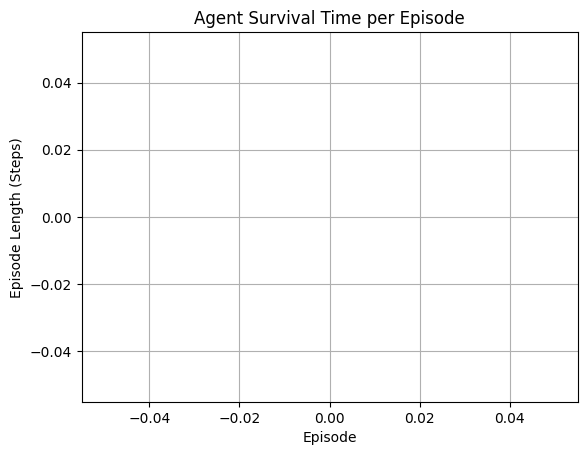

In [15]:
import matplotlib.pyplot as plt
plt.plot(episode_lengths)
plt.xlabel("Episode")
plt.ylabel("Episode Length (Steps)")
plt.title("Agent Survival Time per Episode")
plt.grid(True)
plt.show()